# 훈련 모델 예측 시각화

In [1]:
# -*- coding: utf-8 -*-
import os,sys
sys.path.append(os.getcwd())
import torch
from model.unet_model import Ringed_Res_Unet # 사용 모델
from dataset.Defacto import test # defacto 데이터셋 한정 테스트 모듈
import torch.nn.functional as F
import torch.nn as nn
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# RRU-Net pre-trained
# rru_net = Ringed_Res_Unet().cuda()
# rru_net.load_state_dict(torch.load('../RRUNet/best_model.pth'))
rru_net = Ringed_Res_Unet().cuda()
rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/defactor-[val_dice]-0.7420-[train_loss]-0.0753.pkl')) # copy-move / epoch = 100, (800,256,256,3), batch 6 
# rru_net.load_state_dict(torch.load('./result/logs/defactor/Ringed_Res_Unet/sp_100_defactor-[val_dice]-0.4487-[train_loss]-1.3824.pkl')) # splicing / epoch = 100, (800,256,256,3), batch 6 

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2000
torch.Size([1, 3, 256, 256])
torch.Size([256, 256, 3])


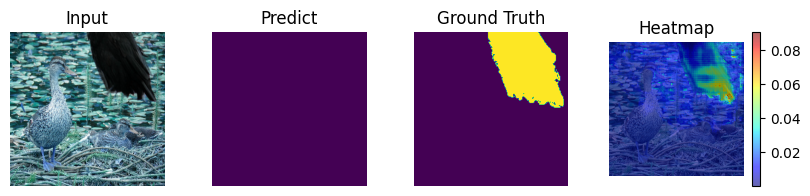

In [8]:
INDEX =  60# 100
MODE = 'te1st' # 'any' : no purmute , no normalize / 'test' same 'train' condition
DIR_IMG = r"E:\splicing_2_img\img"
DIR_MASK = r"E:\splicing_2_annotations\probe_mask"
IMG_SIZE = 256

device = torch.device("cuda:0")
pred,img,mask = test(rru_net,device,INDEX,MODE,IMG_SIZE,DIR_IMG,DIR_MASK)
if MODE not in ['test','train']:
    img = img.permute(1,2,0)
    
print(img.shape)

pred = F.sigmoid(pred)

pred_ = pred[0,:,:,:]
pred_ = pred_.permute(1,2,0)
pred_ = pred_.to('cpu').detach().numpy()

plt.figure(figsize=(10,2))
plt.subplot(141)
plt.imshow(img)
plt.title('Input')
plt.axis('off')
plt.subplot(142)
plt.imshow(pred_>0.5)#,cmap='jet',interpolation='nearest')
plt.title('Predict')
plt.axis('off')
plt.subplot(143)
plt.imshow(mask)
plt.title('Ground Truth')
plt.axis('off')
plt.subplot(144)
plt.imshow(img)
plt.imshow(pred_.squeeze(-1) ,alpha=0.6,cmap='jet')
plt.title('Heatmap')
plt.colorbar()
plt.axis('off')
plt.show()

In [5]:
def use_cv_heatap():
    heatmap = torch.mean(pred.to('cpu'), dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    print('heatmap m n : ',heatmap.min(),heatmap.max())
    heatmap = np.uint8(heatmap*255)
    print('heatmap m n : ',heatmap.min(),heatmap.max(),heatmap.shape)
    heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
    print('heatmap m n : ',heatmap.min(),heatmap.max())
    im = img.numpy()
    im = (im-im.min())
    im = (im/im.max())

    print('im m n : ',im.min(),im.max())
    heatmap_img = (heatmap*0.4 + im)
    # cv.imshow('Jet',heatmap_img)
    # cv.waitKey(0)
    # cv.destroyAllWindows()
    plt.imshow(heatmap_img)
    plt.show()

In [4]:
from torchsummary import summary
summary(rru_net,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         GroupNorm-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
         GroupNorm-5         [-1, 32, 256, 256]              64
   RRU_double_conv-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 32, 256, 256]              96
         GroupNorm-8         [-1, 32, 256, 256]              64
              ReLU-9         [-1, 32, 256, 256]               0
           Conv2d-10          [-1, 3, 256, 256]              96
           Conv2d-11         [-1, 32, 256, 256]             896
        GroupNorm-12         [-1, 32, 256, 256]              64
             ReLU-13         [-1, 32, 256, 256]               0
           Conv2d-14         [-1, 32, 2

In [3]:
import jpegio
import PIL.Image as Image
import numpy as np

def get_jpeg_info( im_path:str):
        """
        :param im_path: JPEG image path
        :return: DCT_coef (Y,Cb,Cr), qtables (Y,Cb,Cr)
        """
        num_channels =  3#self.DCT_channels
        if im_path[-3:] == "tif":
            print('tiff file')
            outfile = "./test.jpg"
            im = Image.open(im_path)
            out = im.convert("RGB")
            out.save(outfile, "JPEG", quality=90)

        jpeg = jpegio.read(str(outfile))

        # determine which axes to up-sample
        ci = jpeg.comp_info
        need_scale = [[ci[i].v_samp_factor, ci[i].h_samp_factor] for i in range(num_channels)]
        if num_channels == 3:
            if ci[0].v_samp_factor == ci[1].v_samp_factor == ci[2].v_samp_factor:
                need_scale[0][0] = need_scale[1][0] = need_scale[2][0] = 2
            if ci[0].h_samp_factor == ci[1].h_samp_factor == ci[2].h_samp_factor:
                need_scale[0][1] = need_scale[1][1] = need_scale[2][1] = 2
        else:
            need_scale[0][0] = 2
            need_scale[0][1] = 2

        # up-sample DCT coefficients to match image size
        DCT_coef = []
        for i in range(num_channels):
            r, c = jpeg.coef_arrays[i].shape
            coef_view = jpeg.coef_arrays[i].reshape(r//8, 8, c//8, 8).transpose(0, 2, 1, 3)
            # case 1: row scale (O) and col scale (O)
            if need_scale[i][0]==1 and need_scale[i][1]==1:
                out_arr = np.zeros((r * 2, c * 2))
                out_view = out_arr.reshape(r * 2 // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, ::2, :, :] = coef_view[:, :, :, :]
                out_view[::2, 1::2, :, :] = coef_view[:, :, :, :]
                out_view[1::2, 1::2, :, :] = coef_view[:, :, :, :]

            # case 2: row scale (O) and col scale (X)
            elif need_scale[i][0]==1 and need_scale[i][1]==2:
                out_arr = np.zeros((r * 2, c))
                DCT_coef.append(out_arr)
                out_view = out_arr.reshape(r*2//8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[::2, :, :, :] = coef_view[:, :, :, :]
                out_view[1::2, :, :, :] = coef_view[:, :, :, :]

            # case 3: row scale (X) and col scale (O)
            elif need_scale[i][0]==2 and need_scale[i][1]==1:
                out_arr = np.zeros((r, c * 2))
                out_view = out_arr.reshape(r // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, ::2, :, :] = coef_view[:, :, :, :]
                out_view[:, 1::2, :, :] = coef_view[:, :, :, :]

            # case 4: row scale (X) and col scale (X)
            elif need_scale[i][0]==2 and need_scale[i][1]==2:
                out_arr = np.zeros((r, c))
                out_view = out_arr.reshape(r // 8, 8, c // 8, 8).transpose(0, 2, 1, 3)
                out_view[:, :, :, :] = coef_view[:, :, :, :]

            else:
                raise KeyError("Something wrong here.")

            DCT_coef.append(out_arr)

        # quantization tables
        qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]

        return DCT_coef, qtables

In [2]:
dct,qtables = get_jpeg_info(r"C:\Users\zxcas\PythonWork\DATASETS\Forgery\copymove_img\img\0_000000000071.tif")
print(dct)
print(qtables)

tiff file
[array([[61.,  0.,  0., ...,  0.,  0.,  0.],
       [-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[69.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[-65.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])]
[array([[ 3.,  2.,  2.,  3.,  5.,  8., 10., 12.],
       [ 2.,  2.,  3.,  4.,  5., 12., 12., 11.],
       [ 3.,  3.,  3

C:\Users\zxcas\AppData\Local\Temp\ipykernel_6264\9212371.py:73: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]


(896, 1200)


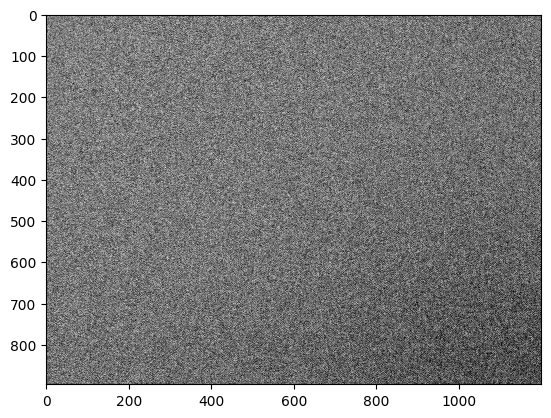

In [23]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt # 시각화

image = cv.imread('CAT-Net\input\example.jpg')
ycbcr = cv.cvtColor(image, cv.COLOR_BGR2YCR_CB)

B = np.array(ycbcr)[:,:,0]
imf = np.float32(B)/255.0
dct = cv.dct(imf)
imgcv1 = np.uint8(dct*255.0)
print (B.shape)
plt.imshow(imgcv1, cmap="gray")
plt.show()

In [25]:
_crop_size = (256,256)
_grid_crop = True
_blocks = ['RGB', 'DCTcoef', 'DCTvol', 'qtable']
tamp_list = None
DCT_channels = 3

In [5]:
import jpegio
import numpy as np

def _get_jpeg_info(im_path): # channels에 해당되는 계수 구하는 함수
    """
    :param im_path: JPEG image path
    :return: DCT_coef (Y,Cb,Cr), qtables (Y,Cb,Cr)
    """
    num_channels = 1 # DCT_channels엔 1, 2, 3 올 수 있음
    jpeg = jpegio.read(str(im_path))
    # determine which axes to up-sample
    ci = jpeg.comp_info
    need_scale = [[ci[i].v_samp_factor, ci[i].h_samp_factor] for i in range(num_channels)]
    if num_channels == 3:
        if ci[0].v_samp_factor == ci[1].v_samp_factor == ci[2].v_samp_factor:
            need_scale[0][0] = need_scale[1][0] = need_scale[2][0] = 2
        if ci[0].h_samp_factor == ci[1].h_samp_factor == ci[2].h_samp_factor:
            need_scale[0][1] = need_scale[1][1] = need_scale[2][1] = 2
    else:
        need_scale[0][0] = 2
        need_scale[0][1] = 2

    # up-sample DCT coefficients to match image size
    DCT_coef = []
    for i in range(num_channels):
        r, c = jpeg.coef_arrays[i].shape
        coef_view = jpeg.coef_arrays[i].reshape(r//8, 8, c//8, 8).transpose(0, 2, 1, 3)
        # case 1: row scale (O) and col scale (O)
        if need_scale[i][0]==1 and need_scale[i][1]==1:
            out_arr = np.zeros((r * 2, c * 2))
            out_view = out_arr.reshape(r * 2 // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
            out_view[::2, ::2, :, :] = coef_view[:, :, :, :]
            out_view[1::2, ::2, :, :] = coef_view[:, :, :, :]
            out_view[::2, 1::2, :, :] = coef_view[:, :, :, :]
            out_view[1::2, 1::2, :, :] = coef_view[:, :, :, :]

        # case 2: row scale (O) and col scale (X)
        elif need_scale[i][0]==1 and need_scale[i][1]==2:
            out_arr = np.zeros((r * 2, c))
            DCT_coef.append(out_arr)
            out_view = out_arr.reshape(r*2//8, 8, c // 8, 8).transpose(0, 2, 1, 3)
            out_view[::2, :, :, :] = coef_view[:, :, :, :]
            out_view[1::2, :, :, :] = coef_view[:, :, :, :]

        # case 3: row scale (X) and col scale (O)
        elif need_scale[i][0]==2 and need_scale[i][1]==1:
            out_arr = np.zeros((r, c * 2))
            out_view = out_arr.reshape(r // 8, 8, c * 2 // 8, 8).transpose(0, 2, 1, 3)
            out_view[:, ::2, :, :] = coef_view[:, :, :, :]
            out_view[:, 1::2, :, :] = coef_view[:, :, :, :]

        # case 4: row scale (X) and col scale (X)
        elif need_scale[i][0]==2 and need_scale[i][1]==2:
            out_arr = np.zeros((r, c))
            out_view = out_arr.reshape(r // 8, 8, c // 8, 8).transpose(0, 2, 1, 3)
            out_view[:, :, :, :] = coef_view[:, :, :, :]

        else:
            raise KeyError("Something wrong here.")

        DCT_coef.append(out_arr)

    # quantization tables
    qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]

    return DCT_coef, qtables

dct,qtables = _get_jpeg_info("test.jpg")

dct = np.array(dct)
dct.shape

qtables = np.array(qtables)
qtables.shape

C:\Users\zxcas\AppData\Local\Temp\ipykernel_3748\1785336283.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]


(1, 8, 8)

In [18]:
import random
from PIL import Image
import torch

# crop_size=(512,512), grid_crop=True, blocks=('RGB', 'DCTvol', 'qtable'), mode='train', DCT_channels=1

def _create_tensor(im_path, mask):
    _crop_size=(512,512)
    _grid_crop=True
    _blocks=('RGB', 'DCTvol', 'qtable')
    mode='train'
    DCT_channels=1
    
    ignore_index = -1

    img_RGB = np.array(Image.open(im_path).convert("RGB"))
    
    h, w = img_RGB.shape[0], img_RGB.shape[1]

    if 'DCTcoef' in _blocks or 'DCTvol' in _blocks or 'rawRGB' in _blocks or 'qtable' in _blocks:
        DCT_coef, qtables = _get_jpeg_info(im_path) 

    if mask is None:
        mask = np.zeros((h, w)) # h, w 0으로 초기화

    # :param crop_size: (H, W) or None. H and W must be the multiple of 8 if grid_crop==True.  
    # :param grid_crop: T: crop within 8x8 grid. F: crop anywhere.
    
    if _crop_size is None and _grid_crop:
        crop_size = (-(-h//8) * 8, -(-w//8) * 8)  # smallest 8x8 grid crop that contains image
    elif _crop_size is None and not _grid_crop:
        crop_size = None  # use entire image! no crop, no pad, no DCTcoef or rawRGB
    else:
        crop_size = _crop_size

    if crop_size is not None:
        # Pad if crop_size is larger than image size
        if h < crop_size[0] or w < crop_size[1]:
            # pad img_RGB
            temp = np.full((max(h, crop_size[0]), max(w, crop_size[1]), 3), 127.5)
            temp[:img_RGB.shape[0], :img_RGB.shape[1], :] = img_RGB
            img_RGB = temp

            # pad mask
            temp = np.full((max(h, crop_size[0]), max(w, crop_size[1])), ignore_index)  # pad with ignore_index(-1)
            temp[:mask.shape[0], :mask.shape[1]] = mask
            mask = temp

            # pad DCT_coef
            if 'DCTcoef' in _blocks or 'DCTvol' in _blocks or 'rawRGB' in _blocks:
                max_h = max(crop_size[0], max([DCT_coef[c].shape[0] for c in range(DCT_channels)]))
                max_w = max(crop_size[1], max([DCT_coef[c].shape[1] for c in range(DCT_channels)]))
                for i in range(DCT_channels):
                    temp = np.full((max_h, max_w), 0.0)  # pad with 0
                    temp[:DCT_coef[i].shape[0], :DCT_coef[i].shape[1]] = DCT_coef[i][:, :]
                    DCT_coef[i] = temp

        # Determine where to crop
        if _grid_crop:
            s_r = (random.randint(0, max(h - crop_size[0], 0)) // 8) * 8 # 0에서 max(h - crop_size[0]까지 임의의 정수 반환
            s_c = (random.randint(0, max(w - crop_size[1], 0)) // 8) * 8
        else:
            s_r = random.randint(0, max(h - crop_size[0], 0))
            s_c = random.randint(0, max(w - crop_size[1], 0))

        # crop img_RGB
        img_RGB = img_RGB[s_r:s_r+crop_size[0], s_c:s_c+crop_size[1], :]

        # crop mask
        mask = mask[s_r:s_r + crop_size[0], s_c:s_c + crop_size[1]]

        # crop DCT_coef
        if 'DCTcoef' in _blocks or 'DCTvol' in _blocks or 'rawRGB' in _blocks:
            for i in range(DCT_channels):
                DCT_coef[i] = DCT_coef[i][s_r:s_r+crop_size[0], s_c:s_c+crop_size[1]]
            t_DCT_coef = torch.tensor(DCT_coef, dtype=torch.float)  # final (but used below)

    # handle 'RGB'
    if 'RGB' in _blocks:
        t_RGB = (torch.tensor(img_RGB.transpose(2,0,1), dtype=torch.float)-127.5)/127.5  # final

    # handle 'DCTvol'
    if 'DCTvol' in _blocks:
        T = 20
        t_DCT_vol = torch.zeros(size=(T+1, t_DCT_coef.shape[1], t_DCT_coef.shape[2]))
        t_DCT_vol[0] += (t_DCT_coef == 0).float().squeeze()
        for i in range(1, T):
            t_DCT_vol[i] += (t_DCT_coef == i).float().squeeze()
            t_DCT_vol[i] += (t_DCT_coef == -i).float().squeeze()
        t_DCT_vol[T] += (t_DCT_coef >= T).float().squeeze()
        t_DCT_vol[T] += (t_DCT_coef <= -T).float().squeeze()

    # create tensor
    img_block = []
    for i in range(len(_blocks)):
        if _blocks[i] == 'RGB':
            img_block.append(t_RGB)
        elif _blocks[i] == 'DCTcoef':
            img_block.append(t_DCT_coef)
        elif _blocks[i] == 'DCTvol':
            img_block.append(t_DCT_vol)
        elif _blocks[i] == 'qtable':
            continue
        else:
            raise KeyError("We cannot reach here. Something is wrong.")

    # final tensor
    tensor = torch.cat(img_block)

    if 'qtable' not in _blocks:
        return tensor, torch.tensor(mask, dtype=torch.long), 0
    else:
        return tensor, torch.tensor(mask, dtype=torch.long), torch.tensor(qtables[:DCT_channels], dtype=torch.float)

tensor,mask,qtables =  _create_tensor("test.jpg",None)
tensor.shape

C:\Users\zxcas\AppData\Local\Temp\ipykernel_3748\1785336283.py:65: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  qtables = [jpeg.quant_tables[ci[i].quant_tbl_no].astype(np.float) for i in range(num_channels)]


torch.Size([24, 512, 512])

In [19]:
from torch.nn import BatchNorm2d

def _make_layer(block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=0.01),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)
        
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=0.01)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=0.01)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [22]:
dc_layer0_dil = nn.Sequential(
            nn.Conv2d(in_channels=21,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      dilation=8,
                      padding=8),
            nn.BatchNorm2d(64, momentum=0.01),
            nn.ReLU(inplace=True)
        )
dc_layer1_tail = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(4, momentum=0.01),
            nn.ReLU(inplace=True)
        )

# last_layer = nn.Sequential(
#             nn.Conv2d(
#                 in_channels=last_inp_channels,
#                 out_channels=last_inp_channels,
#                 kernel_size=1,
#                 stride=1,
#                 padding=0),
#             BatchNorm2d(last_inp_channels, momentum=0.01),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(
#                 in_channels=last_inp_channels,
#                 out_channels=2,
#                 kernel_size=1,
#                 stride=1,
#                 padding=1 if 1 == 3 else 0)
#         )

def forward( x, qtable):
        RGB, DCTcoef = x[:, :3, :, :], x[:, 3:, :, :]

        
        # DCT Stream
        x = dc_layer0_dil(DCTcoef)
        x = dc_layer1_tail(x)
        B, C, H, W = x.shape
        x0 = x.reshape(B, C, H // 8, 8, W // 8, 8).permute(0, 1, 3, 5, 2, 4).reshape(B, 64 * C, H // 8,
                                                                                     W // 8)  # [B, 256, 32, 32]
        x_temp = x.reshape(B, C, H // 8, 8, W // 8, 8).permute(0, 1, 3, 5, 2, 4)  # [B, C, 8, 8, 32, 32]
        q_temp = qtable.unsqueeze(-1).unsqueeze(-1)  # [B, 1, 8, 8, 1, 1]
        xq_temp = x_temp * q_temp  # [B, C, 8, 8, 32, 32]
        x1 = xq_temp.reshape(B, 64 * C, H // 8, W // 8)  # [B, 256, 32, 32]
        x = torch.cat([x0, x1], dim=1)
        print(x.shape)
       
       
        return x

result = forward(tensor.unsqueeze(0),qtables)
result.shape

torch.Size([1, 512, 64, 64])


torch.Size([1, 512, 64, 64])

In [23]:
# network 정의
from model.unet_parts import *
class FC_DCTNet(nn.Module):
    def __init__(self,in_ch,n_classes):
        super().__init__() 
        # (B,512,64,64)
        self.down = RRU_first_down(in_ch, 256)
        self.down1 = RRU_down(256, 256) # 32
        self.down2 = RRU_down(256, 64) # 16
        self.down3 = RRU_down(64, 32) # 8
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512,n_classes)
        self.relu = nn.ReLU()

    def forward(self,x): # 일단 jpeg 학습 모듈 ouput이 (B,512,64,64)
        x = self.down(x)
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        

        return x

In [ ]:
import torch
import torch.nn as nn
import torch._utils
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
BN_MOMENTUM = 0.01

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class CAT_Net(nn.Module):
    def __init__(self, config, **kwargs):
        extra = config.MODEL.EXTRA
        super(CAT_Net, self).__init__()

        # DCT coefficient branch
        self.dc_layer0_dil = nn.Sequential(
            nn.Conv2d(in_channels=21,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      dilation=8,
                      padding=8),
            nn.BatchNorm2d(64, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True)
        )
        self.dc_layer1_tail = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(4, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True)
        )
        self.dc_layer2 = self._make_layer(BasicBlock, inplanes=4 * 64 * 2, planes=96, blocks=4, stride=1)

        self.dc_stage3_cfg = extra['DC_STAGE3']
        num_channels = 3
        block = blocks_dict["BASIC"]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.dc_transition2 = self._make_transition_layer(
            [96], num_channels)
        self.dc_stage3, pre_stage_channels = self._make_stage(
            self.dc_stage3_cfg, num_channels)

        self.dc_stage4_cfg = extra['DC_STAGE4']
        num_channels = [96,192,384]
        block = blocks_dict['BASIC']
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.dc_transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.dc_stage4, DC_final_stage_channels = self._make_stage(
            self.dc_stage4_cfg, num_channels, multi_scale_output=True)

        DC_final_stage_channels.insert(0, 0)  # to match # branches

        # stage 5
        self.stage5_cfg = extra['STAGE5']
        num_channels = [24,48,96,192]
        block = blocks_dict['BASIC']
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition4 = self._make_transition_layer(
            [i+j for (i, j) in zip(RGB_final_channels, DC_final_stage_channels)], num_channels)
        self.stage5, pre_stage_channels = self._make_stage(
            self.stage5_cfg, num_channels)

        last_inp_channels = sum(pre_stage_channels)
        self.last_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=last_inp_channels,
                kernel_size=1,
                stride=1,
                padding=0),
            BatchNorm2d(last_inp_channels, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=last_inp_channels,
                out_channels=2,
                kernel_size=1,
                stride=1,
                padding=1 if 1 == 3 else 0)
        )

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i + 1 - num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i - num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x, qtable):
        RGB, DCTcoef = x[:, :3, :, :], x[:, 3:, :, :]

       

        # DCT Stream
        x = self.dc_layer0_dil(DCTcoef)
        x = self.dc_layer1_tail(x)
        B, C, H, W = x.shape
        x0 = x.reshape(B, C, H // 8, 8, W // 8, 8).permute(0, 1, 3, 5, 2, 4).reshape(B, 64 * C, H // 8,
                                                                                     W // 8)  # [B, 256, 32, 32]
        x_temp = x.reshape(B, C, H // 8, 8, W // 8, 8).permute(0, 1, 3, 5, 2, 4)  # [B, C, 8, 8, 32, 32]
        q_temp = qtable.unsqueeze(-1).unsqueeze(-1)  # [B, 1, 8, 8, 1, 1]
        xq_temp = x_temp * q_temp  # [B, C, 8, 8, 32, 32]
        x1 = xq_temp.reshape(B, 64 * C, H // 8, W // 8)  # [B, 256, 32, 32]
        x = torch.cat([x0, x1], dim=1)
        x = self.dc_layer2(x)  # x.shape = torch.Size([1, 96, 64, 64])

        x_list = []
        for i in range(3):
            if self.dc_transition2[i] is not None:
                x_list.append(self.dc_transition2[i](x))
            else:
                x_list.append(x)
        y_list = self.dc_stage3(x_list)

        x_list = []
        for i in range(4):
            if self.dc_transition3[i] is not None:
                x_list.append(self.dc_transition3[i](y_list[-1]))
            else:
                x_list.append(y_list[i])
        DC_list = self.dc_stage4(x_list)


        # Upsampling
        x0_h, x0_w = x[0].size(2), x[0].size(3)
        x1 = F.upsample(x[1], size=(x0_h, x0_w), mode='bilinear')
        x2 = F.upsample(x[2], size=(x0_h, x0_w), mode='bilinear')
        x3 = F.upsample(x[3], size=(x0_h, x0_w), mode='bilinear')

        x = torch.cat([x[0], x1, x2, x3], 1)

        x = self.last_layer(x)

        return x

    def init_weights(self, pretrained_rgb='', pretrained_dct='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained_rgb):
            loaded_dict = torch.load(pretrained_rgb)
            model_dict = self.state_dict()
            loaded_dict = {k: v for k, v in loaded_dict.items()
                               if k in model_dict.keys() and not k.startswith('lost_layer.')}  # RGB weight
            logger.info('=> (RGB) loading pretrained model {} ({})'.format(pretrained_rgb, len(loaded_dict)))
            model_dict.update(loaded_dict)
            self.load_state_dict(model_dict)
        else:
            logger.warning('=> Cannot load pretrained RGB')
        if os.path.isfile(pretrained_dct):
            loaded_dict = torch.load(pretrained_dct)['state_dict']
            model_dict = self.state_dict()
            loaded_dict = {k: v for k, v in loaded_dict.items()
                               if k in model_dict.keys()}
            loaded_dict = {k:v for k,v in loaded_dict.items()
                           if not k.startswith('last_layer')}
            logger.info('=> (DCT) loading pretrained model {} ({})'.format(pretrained_dct, len(loaded_dict)))
            model_dict.update(loaded_dict)
            self.load_state_dict(model_dict)
        else:
            logger.warning('=> Cannot load pretrained DCT')